# PyTorch Neural Network Classification

### Make classification data and get it ready

In [7]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
print(circles.head())
circles.label.value_counts()

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0


label
1    500
0    500
Name: count, dtype: int64

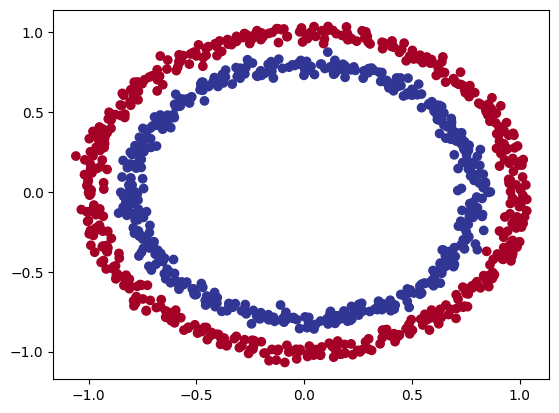

In [8]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


Split the data into train and test

In [10]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Simple model and training

In [11]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [12]:
from torch import nn

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [15]:
# Training loop

epochs = 100

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model_0.eval()
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model_0(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits,
                                y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70432, Accuracy: 51.88% | Test loss: 0.69496, Test acc: 51.50%
Epoch: 10 | Loss: 0.69972, Accuracy: 50.75% | Test loss: 0.69290, Test acc: 51.00%
Epoch: 20 | Loss: 0.69733, Accuracy: 51.12% | Test loss: 0.69227, Test acc: 51.00%
Epoch: 30 | Loss: 0.69595, Accuracy: 50.75% | Test loss: 0.69221, Test acc: 50.50%
Epoch: 40 | Loss: 0.69510, Accuracy: 49.38% | Test loss: 0.69236, Test acc: 50.50%
Epoch: 50 | Loss: 0.69453, Accuracy: 49.75% | Test loss: 0.69259, Test acc: 51.00%
Epoch: 60 | Loss: 0.69413, Accuracy: 50.12% | Test loss: 0.69284, Test acc: 48.00%
Epoch: 70 | Loss: 0.69385, Accuracy: 50.00% | Test loss: 0.69308, Test acc: 48.50%
Epoch: 80 | Loss: 0.69365, Accuracy: 50.38% | Test loss: 0.69330, Test acc: 49.50%
Epoch: 90 | Loss: 0.69350, Accuracy: 50.38% | Test loss: 0.69351, Test acc: 50.50%


It looks like it went through the training and testing steps fine but the results don't seem to have moved too much.

Let's see what the model's predictions look like

In [16]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

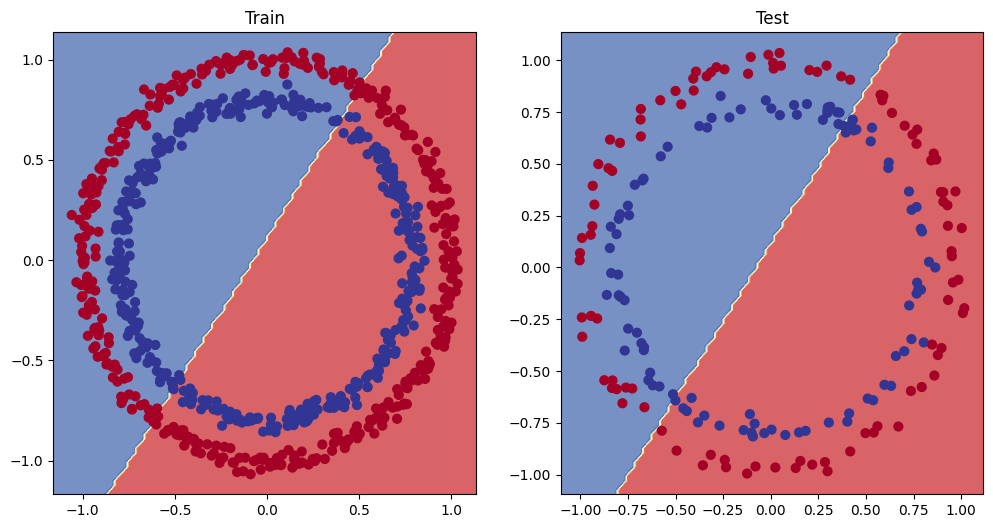

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model 

In [22]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [23]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [24]:
torch.manual_seed(42)
epochs = 1001

for epoch in range(epochs):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    if epoch % 100 == 0:
        model_3.eval()
        with torch.inference_mode():
            test_logits = model_3(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
            
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                    y_pred=test_pred)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%


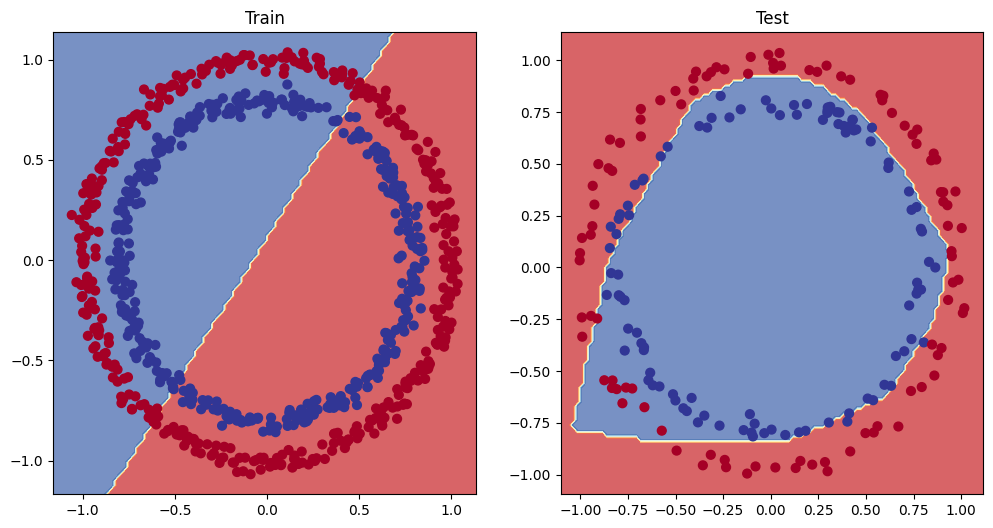

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity